In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import matplotlib.pyplot as plt
from training.util import plot_losses, GaussWrapper, sgd, adam
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training import toy
from experiments.base.toy_regression import gap_datasets, plot_grid, store_results, NOISE, wrap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = torch.device("cpu")

In [22]:
from training.pp import PointPredictor
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel
from training.gp import GaussianProcess

def train_models(dataset, batch_size):
    torch.manual_seed(42)
    trainloader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)


    # torch.manual_seed(42)
    # gp = GaussianProcess(dataset.normalized_xs, dataset.normalized_ys, NOISE / dataset.y_std**2)
    # gp.train_model(100, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    pp = wrap(PointPredictor(layers), dataset)
    pp.train_model(80, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    swag_config = {
        "start_epoch": 50,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    swag = wrap(SwagModel(layers, swag_config), dataset)
    swag.train_model(80, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    diag_swag_config = {
        "start_epoch": 50,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30,
        "use_low_rank_cov": False
    }
    diag_swag = wrap(SwagModel(layers, diag_swag_config), dataset)
    diag_swag.train_model(80, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    multi_swag_config = {
        "start_epoch": 50,
        "update_every_batches": len(trainloader),
        "deviation_samples": 30
    }
    multi_swag = Ensemble([wrap(SwagModel(layers, multi_swag_config), dataset) for _ in range(5)])
    multi_swag.train_model(80, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    ensemble = Ensemble([wrap(PointPredictor(layers), dataset) for _ in range(10)])
    ensemble.train_model(80, adam(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    mc_dropout = wrap(PointPredictor(layers), dataset)
    mc_dropout.train_model(100, adam(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)

    torch.manual_seed(42)
    layers = [
        ("fc", (1, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 32)),
        ("dropout", (0.1,)),
        ("relu", ()),
        ("fc", (32, 1))
    ]
    multi_mc_dropout = Ensemble([wrap(PointPredictor(layers), dataset) for _ in range(5)])
    multi_mc_dropout.train_model(100, adam(0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1)


    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior, {"rho_init": -3}))
    ]
    bbb = wrap(BBBModel(layers), dataset)
    bbb.train_model(120, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    bbb_prior = GaussianPrior(0, 1)
    layers = [
        ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
        ("relu", ()),
        ("v_fc", (32, 1, bbb_prior, {"rho_init": -3}))
    ]
    multi_bbb = Ensemble([wrap(BBBModel(layers), dataset) for _ in range(5)])
    multi_bbb.train_model(120, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5,  mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 2, 1, {"rho_init": -3, "offdiag_init": 0.05})),
        ("relu", ()),
        ("vlr_fc", (32, 32, 2, 1, {"rho_init": -3, "offdiag_init": 0.05})),
        ("relu", ()),
        ("vlr_fc", (32, 1, 2, 1, {"rho_init": -3, "offdiag_init": 0.05}))
    ]
    bbb_lr2 = wrap(BBBModel(layers), dataset)
    bbb_lr2.train_model(120, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)

    torch.manual_seed(42)
    layers = [
        ("vlr_fc", (1, 32, 10, 1, {"rho_init": -3, "offdiag_init": 0.05})),
        ("relu", ()),
        ("vlr_fc", (32, 32, 10, 1, {"rho_init": -3, "offdiag_init": 0.05})),
        ("relu", ()),
        ("vlr_fc", (32, 1, 10, 1, {"rho_init": -3, "offdiag_init": 0.05}))
    ]
    bbb_lr10 = wrap(BBBModel(layers), dataset)
    bbb_lr10.train_model(120, adam(lr=0.001), "mean", trainloader, batch_size, device, report_every_epochs=-1, kl_rescaling=0.5, mc_samples=2)


    return [pp, ensemble, swag, diag_swag, multi_swag, mc_dropout, multi_mc_dropout, bbb, multi_bbb, bbb_lr2, bbb_lr10]

Training ensemble member 0
Final loss -0.07736346870660782
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Training ensemble member 1
Final loss -0.07362951338291168
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Training ensemble member 2
Final loss -0.0798821821808815
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Training ensemble member 3
Final loss -0.08032261580228806
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Training ensemble member 4
Final loss -0.08008503168821335
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Test LML (SWAG): 1.0297307968139648


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x2a5456395b0>])

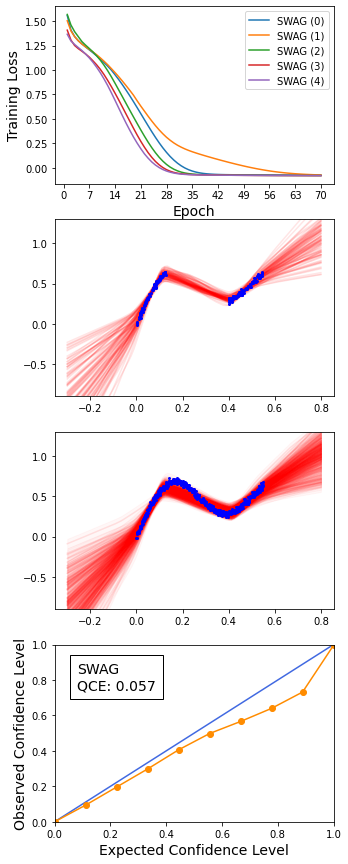

In [14]:
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
multi_swag_config = {
    "start_epoch": 40,
    "update_every_batches": len(trainloader),
    "deviation_samples": 30,
    "use_low_rank_cov": True
}
multi_swag = Ensemble([wrap(SwagModel(layers, multi_swag_config), dataset) for _ in range(5)])
multi_swag.train_model(70, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0)
plot_grid(dataset, testset, [("SWAG", multi_swag, 100)], device, plot_ground_truth=False)

Epoch 0: loss 1.4878164529800415
Epoch 20: loss 0.5038473010063171
Epoch 40: loss -0.0673818364739418
Final loss -0.07044656574726105
Test LML (MAP): 0.2249498814344406


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x2a545016c10>])

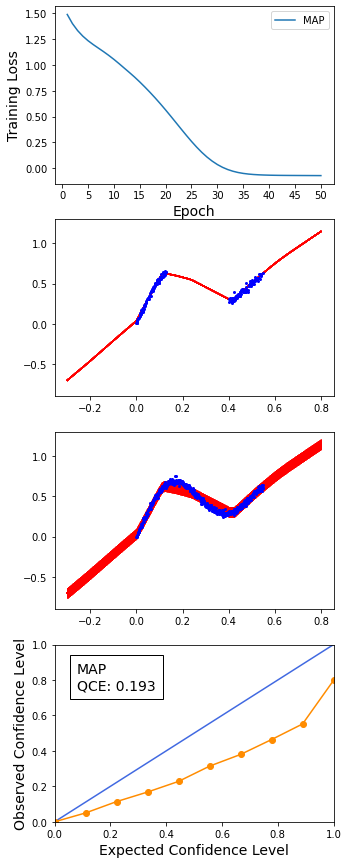

In [13]:
torch.manual_seed(0)

dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
map = wrap(PointPredictor(layers), dataset)
map.train_model(50, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=20)
plot_grid(dataset, testset, [("MAP", map, 100)], device, plot_ground_truth=False)

Epoch 0: loss 1.4556536674499512
Epoch 20: loss 1.3366376161575317
Epoch 40: loss 1.161149501800537
Epoch 60: loss 0.5882259011268616
Epoch 80: loss 0.08816895633935928
Epoch 100: loss 0.0729484036564827
Epoch 120: loss 0.05170411989092827
Epoch 140: loss 0.04754837602376938
Epoch 160: loss 0.02141023799777031
Epoch 180: loss 0.004739691503345966
Final loss 0.029453668743371964
Test LML (BBB): -0.1894780546426773


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x230ffed1be0>])

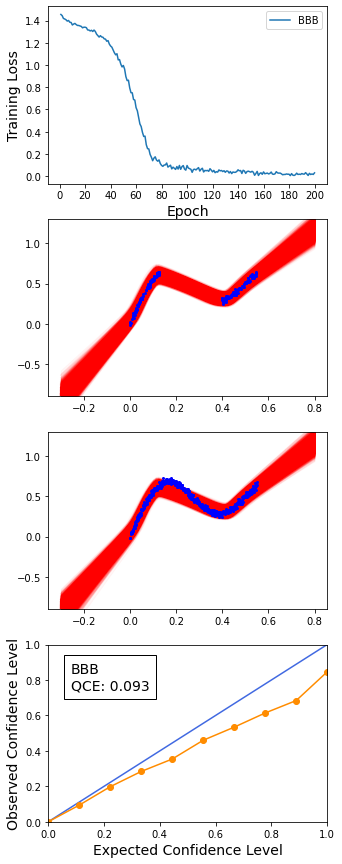

In [48]:
torch.manual_seed(42)

dataset, trainloader, testset = gap_datasets(device)

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (1, 32, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (32, 32, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (32, 1, bbb_prior, {"rho_init": -3}))
]
bbb = wrap(BBBModel(layers), dataset)
bbb.train_model(200, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=20, kl_rescaling=0.5,  mc_samples=2)

plot_grid(dataset, testset, [("BBB", bbb, 1000)], device, plot_ground_truth=False)


torch.Size([1153])
tensor(0.0365, grad_fn=<MinBackward1>)
tensor(0.0486, grad_fn=<MeanBackward0>)
tensor(0.0489, grad_fn=<MaxBackward1>)


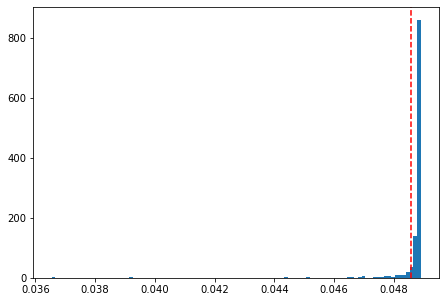

In [50]:
result = torch.tensor([])
for module in bbb.mean.model:
    if (hasattr(module, "sigmas")):
        result = torch.cat([result, module.sigmas()])

plt.hist(result.detach().numpy(), bins=100)[1]
plt.axvline(torch.nn.functional.softplus(torch.tensor(-3.0)), color="red", linestyle="--")
plt.tight_layout(pad=0)
#plt.savefig("results/vi/sigma_hist_1.pdf")
print(result.shape)
print(result.min())
print(result.mean())
print(result.max())

Epoch 0: loss 0.1804710030555725
Epoch 10: loss 0.14776919782161713
Epoch 20: loss 0.12731771171092987
Epoch 30: loss 0.11277168244123459
Epoch 40: loss 0.08076648414134979
Epoch 50: loss 0.056240443140268326
Epoch 60: loss 0.03849610686302185
Epoch 70: loss 0.018342390656471252
Epoch 80: loss 0.0052553946152329445
Epoch 90: loss -0.0022046423982828856
Epoch 100: loss -0.014400874264538288
Epoch 110: loss -0.016283974051475525
Epoch 120: loss -0.02197139710187912
Epoch 130: loss -0.027135400101542473
Epoch 140: loss -0.026440193876624107
Epoch 150: loss -0.02742726169526577
Epoch 160: loss -0.03066180646419525
Epoch 170: loss -0.029559627175331116
Epoch 180: loss -0.030726784840226173
Epoch 190: loss -0.03309796378016472
Epoch 200: loss -0.029581697657704353
Epoch 210: loss -0.03253910690546036
Epoch 220: loss -0.03221216797828674
Epoch 230: loss -0.03324364125728607
Epoch 240: loss -0.035061754286289215
Final loss -0.035167209804058075
Test LML (lrvi_10): 0.18796885013580322


(<Figure size 360x1080 with 4 Axes>,
 [<training.regresssion.RegressionResults at 0x18a68b5bb50>])

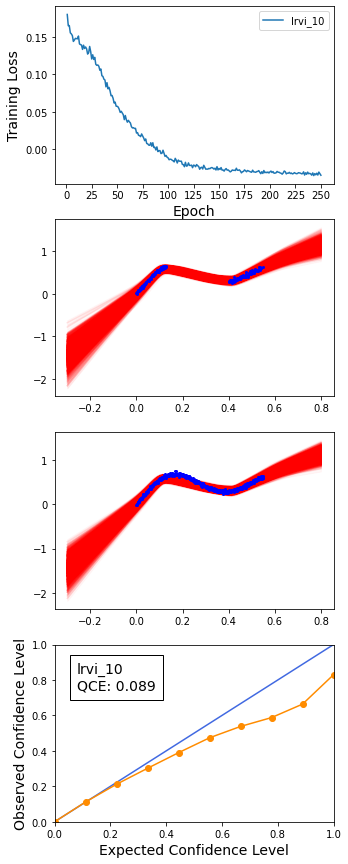

In [73]:
torch.manual_seed(0)

dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("vlr_fc", (1, 32, 10, 1, {"rho_init": -3, "offdiag_init": 0.05})),
    ("relu", ()),
    ("vlr_fc", (32, 32, 10, 1, {"rho_init": -3, "offdiag_init": 0.05})),
    ("relu", ()),
    ("vlr_fc", (32, 1, 10, 1, {"rho_init": -3, "offdiag_init": 0.05}))
]
bbb_lr10 = wrap(BBBModel(layers), dataset)
bbb_lr10.train_model(250, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=10, kl_rescaling=0.5, mc_samples=2)
plot_grid(dataset, testset, [("lrvi_10", bbb_lr10, 1000)], device, plot_ground_truth=False)

In [11]:
results = [[] for _ in range(11)]

for seed in range(10):
    print(f"===== {seed}")
    dataset, trainloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = []
    eval_configs = []
    for K in range(1, 22, 2):
        print(f"== {K}")
        torch.manual_seed(seed)

        layers = [
            ("vlr_fc", (1, 32, K, 1, {"rho_init": -3, "offdiag_init": 0.005})),
            ("relu", ()),
            ("vlr_fc", (32, 32, K, 1, {"rho_init": -3, "offdiag_init": 0.005})),
            ("relu", ()),
            ("vlr_fc", (32, 1, K, 1, {"rho_init": -3, "offdiag_init": 0.005}))
        ]
        bbb_lrK = wrap(BBBModel(layers), dataset)
        bbb_lrK.train_model(250, adam(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0, kl_rescaling=0.5, mc_samples=2)
        models.append(bbb_lrK)
        eval_configs.append((f"LRVI-{K}", bbb_lrK, 1000))

    for i, (name, model, samples) in enumerate(eval_configs):
        results[i].append(RegressionResults(testloader, name, model.infer, samples, device, target_mean=dataset.y_mean, target_std = dataset.y_std))

===== 0
== 1
Final loss -0.037027835845947266
== 3
Final loss -0.03499143198132515
== 5
Final loss -0.03178078681230545
== 7
Final loss -0.03696742653846741
== 9
Final loss -0.03603125736117363
== 11
Final loss -0.035633817315101624
== 13
Final loss -0.03655293583869934
== 15
Final loss -0.03675404191017151
== 17
Final loss -0.03648023307323456
== 19
Final loss -0.03233423829078674
== 21
Final loss -0.036170843988657
===== 1
== 1
Final loss -0.03646283969283104
== 3
Final loss -0.039832357317209244
== 5
Final loss -0.03935950621962547
== 7
Final loss -0.03760188817977905
== 9
Final loss -0.03802187368273735
== 11
Final loss -0.03920073062181473
== 13
Final loss -0.03793386369943619
== 15
Final loss -0.03797808289527893
== 17
Final loss -0.038597311824560165
== 19
Final loss -0.03869035840034485
== 21
Final loss -0.0390123575925827
===== 2
== 1
Final loss -0.03754476457834244
== 3
Final loss -0.03601428121328354
== 5
Final loss -0.038082484155893326
== 7
Final loss -0.03981870412826538


| Gap Toy Regression   | Avg LML      | Mean MSE      | MSE of Means   | QCE         |
|----------------------+--------------+---------------+----------------+-------------|
| LRVI-1               | 0.26 ± 0.18  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-3               | 0.04 ± 0.19  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-5               | 0.02 ± 0.14  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-7               | 0.14 ± 0.24  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-9               | 0.10 ± 0.19  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-11              | 0.06 ± 0.16  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-13              | 0.03 ± 0.17  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-15              | 0.10 ± 0.16  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-17              | 0.12 ± 0.15  | 0.005 ± 0.000 | 0.004 ± 0.000  | 0.09 ± 0.00 |
| LRVI-19              | -0.05 ± 0.14 | 0.0

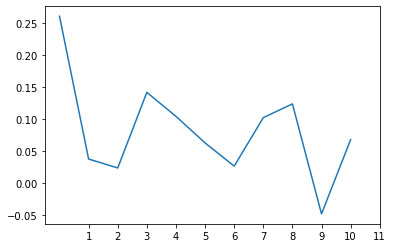

In [12]:
plot_table("Gap Toy Regression", results, "results/toy/regression_gap_lr.txt")

Test LML (BBB LR-1): 0.8295542001724243
Test LML (BBB LR-2): 0.6116978526115417
Test LML (BBB LR-3): 0.8192546963691711
Test LML (BBB LR-4): 0.8078017830848694
Test LML (BBB LR-5): 0.6128537058830261
Test LML (BBB LR-6): 0.8156030774116516
Test LML (BBB LR-7): 1.145634651184082
Test LML (BBB LR-8): 0.805411696434021
Test LML (BBB LR-9): 0.9608200788497925
Test LML (BBB LR-10): 0.9975020885467529
Test LML (BBB LR-11): 0.8234630823135376
Test LML (BBB LR-12): 1.1964620351791382
Test LML (BBB LR-13): 0.8556326031684875
Test LML (BBB LR-14): 0.8968547582626343
Test LML (BBB LR-15): 0.6951597332954407
Test LML (BBB LR-16): 0.6906633973121643
Test LML (BBB LR-17): 0.8977761268615723
Test LML (BBB LR-18): 0.8443577885627747
Test LML (BBB LR-19): 0.7314607501029968
Test LML (BBB LR-20): 0.987156867980957


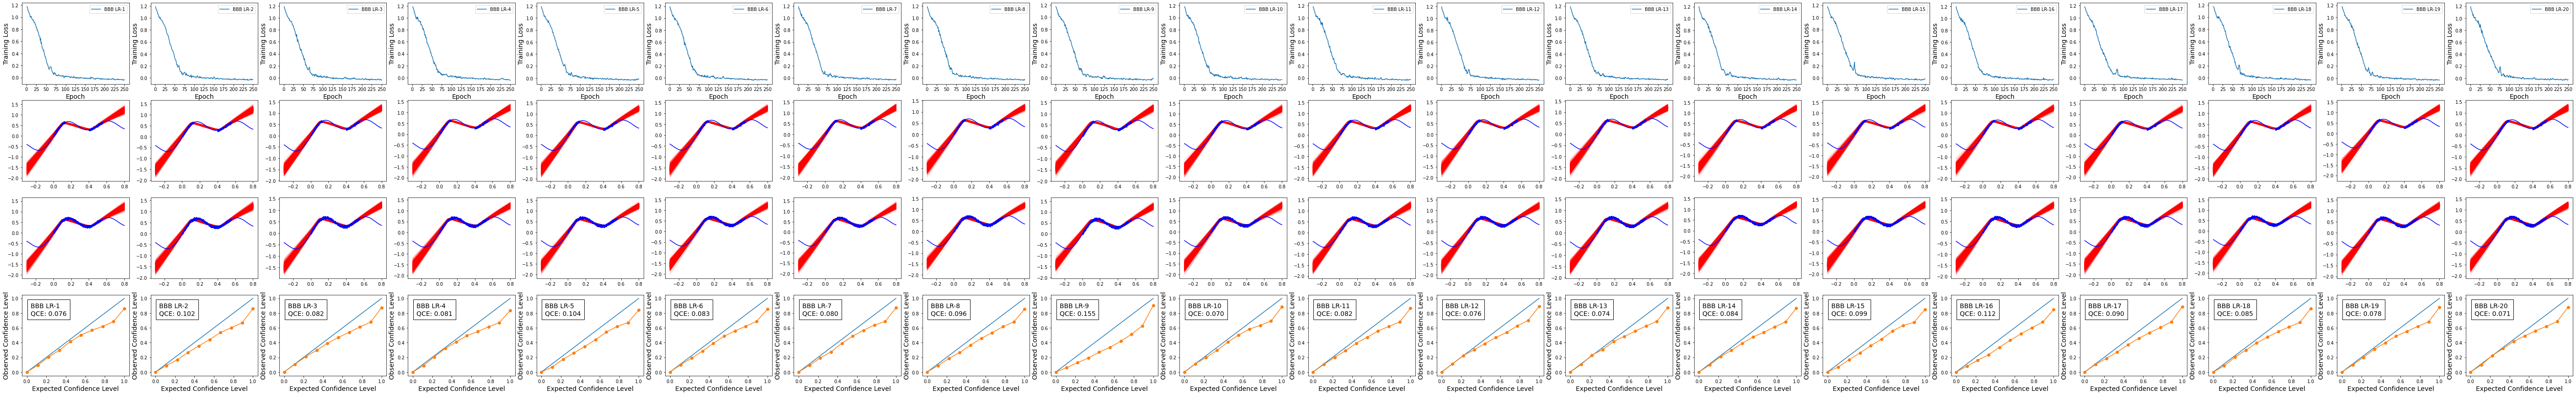

In [78]:
plot_grid(dataset, testset, -0.3, 0.8, eval_configs, device)[0].savefig("results/toy/regression_gap_lr.pdf")

In [ ]:
torch.manual_seed(42)
dataset = toy.TrigonometricToyDataset([(0, 0.5, 200)], noise)
dataset.plot_dataset(-0.2, 0.7, plt.subplot())

models = train_models(dataset, 20)

fig, results = plot_grid(dataset, dataset.generate_testset(0.0, 0.5, 200, noise), -0.1, 0.6, [
    ("Gaussian Process", models[0], 1000),
    ("MAP", models[1], 1000),
    ("Ensemble-5", models[2], 1000),
    ("SWAG", models[3], 1000),
    ("SWAG-Diagonal", models[4], 1000),
    ("MC Dropout", models[5], 1000),
    ("Bayes By Backprop", models[6], 1000),
    ("Bayes By Backprop (LL)", models[7], 1000)
], device)

#fig.savefig("results/toy/regression_simple.png")

#plot_table("Simple Toy Regression", [[result] for result in results], "results/toy/regression_simple.txt")

Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 5
Training ensemble member 6
Training ensemble member 7
Training ensemble member 8
Training ensemble member 9
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Training ensemble member 0
Training ensemble member 1
Training ensemble member 2
Training ensemble member 3
Training ensemble member 4
Test LML (MAP): 0.6401739120483398
Test LML (Ensemble-10): 0.8519220352172852
Test LML (SWAG): 1.6189721822738647
Test LML (SWAG-Diag): 1.1174852848052979
Test LML (MultiSWAG): 1.5649358034133911
Test LML (MC Dropout): 0.7393853068351746
Test LML (Multi MC Dropout): -0.030246948823332787
Test LML (Bayes By Backprop): 0.2078

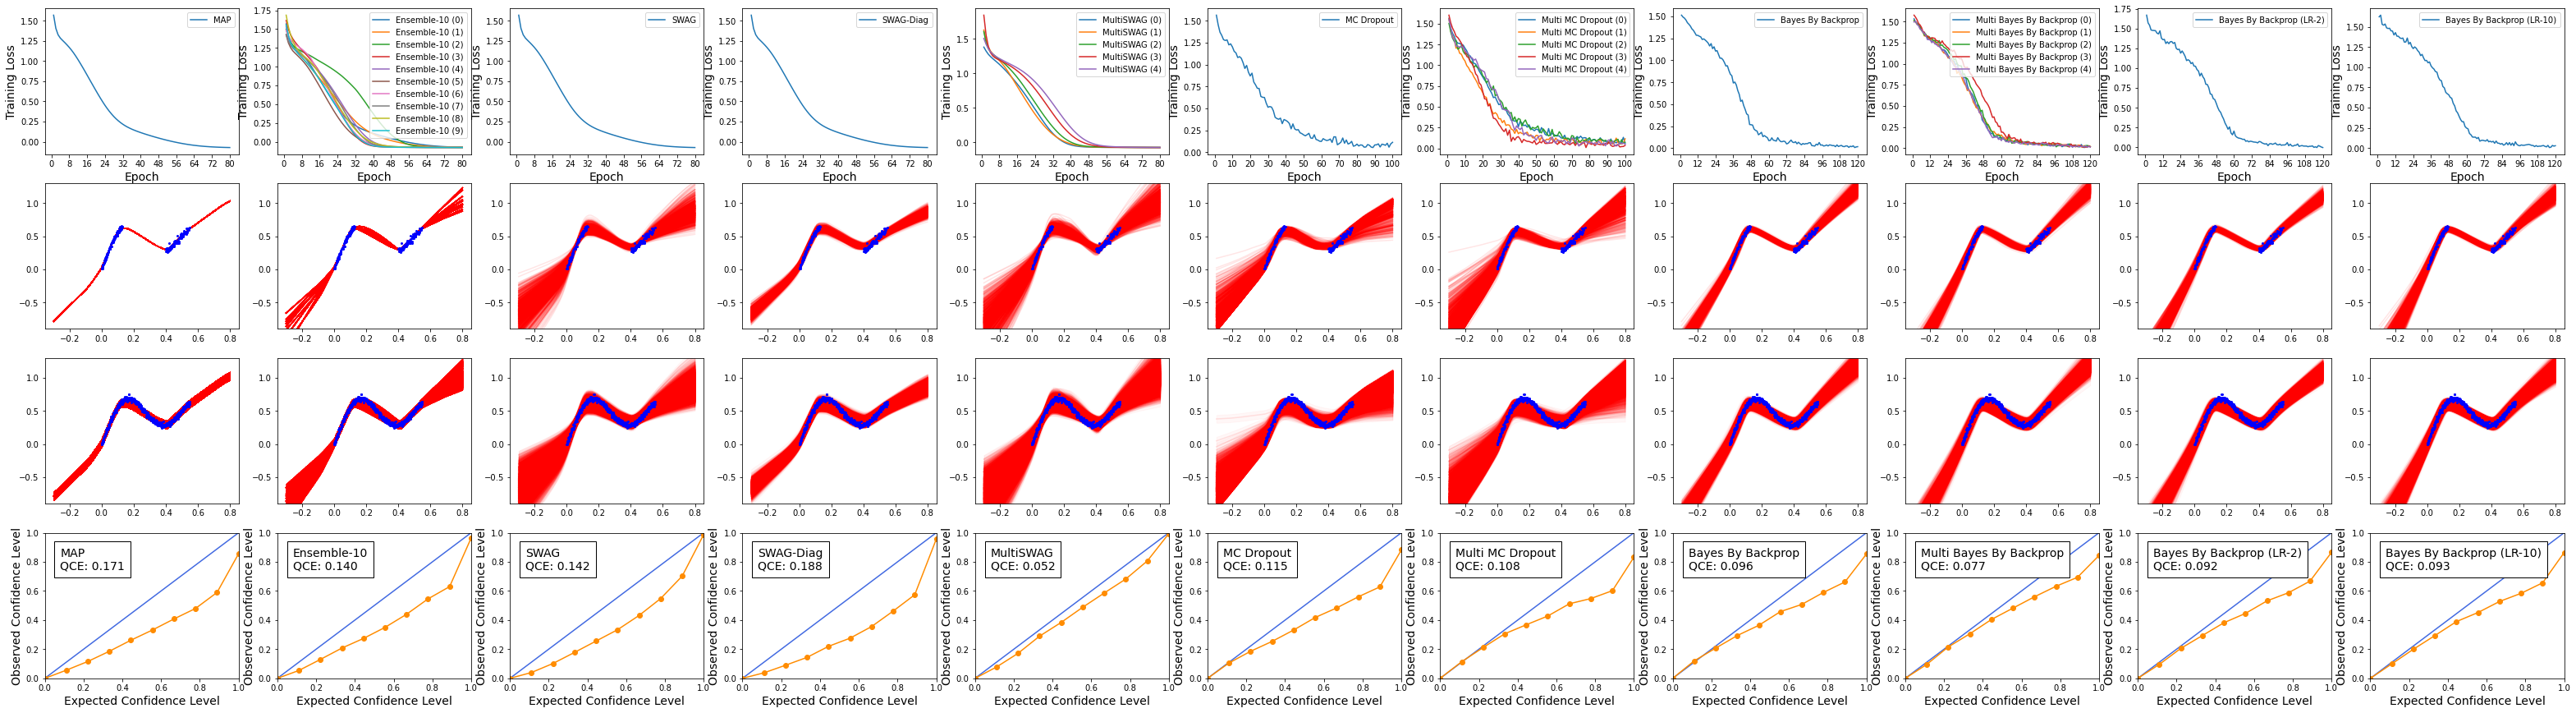

In [23]:
results = [[] for _ in range(11)]
#[pp, ensemble, swag, diag_swag, multi_swag, mc_dropout, multi_mc_dropout, bbb, multi_bbb, bbb_lr2, bbb_lr10]
for seed in range(1):
    torch.manual_seed(seed)
    dataset, dataloader, testset = gap_datasets(device)
    testloader = torch.utils.data.DataLoader(testset, batch_size=testset.tensors[0].shape[0])

    models = train_models(dataset, 20)
    eval_configs = [
        ("MAP", models[0], 1000),
        ("Ensemble-10", models[1], 1000),
        ("SWAG", models[2], 1000),
        ("SWAG-Diag", models[3], 1000),
        ("MultiSWAG", models[4], 1000),
        ("MC Dropout", models[5], 1000),
        ("Multi MC Dropout", models[6], 1000),
        ("Bayes By Backprop", models[7], 1000),
        ("Multi Bayes By Backprop", models[8], 1000),
        ("Bayes By Backprop (LR-2)", models[9], 1000),
        ("Bayes By Backprop (LR-10)", models[10], 1000)
    ]

    # for i, (name, model, samples) in enumerate(eval_configs):
    #     results[i].append(RegressionResults(testloader, name, model.infer, samples, device, target_mean=dataset.y_mean, target_std = dataset.y_std))

#plot_table("Gap Toy Regression", results, "results/toy/regression_gap.txt")

fig, _ = plot_grid(dataset, testset, eval_configs, device, plot_ground_truth=False)
#fig.savefig("results/toy/regression_gap.png")

# store_results(dataset, testset, -0.3, 0.8, [
#     ("gp", models[0], 1000),
#     ("map", models[1], 1000),
#     ("ensemble", models[2], 1000),
#     ("swag", models[3], 1000),
#     ("swag_diag", models[4], 1000),
#     ("mc_dropout", models[5], 1000),
#     ("bbb", models[6], 1000),
#     ("bbb_ll", models[7], 1000)
# ], device)

Training ensemble member 0
Final loss -0.05954016372561455
Training ensemble member 1
Final loss -0.06503313779830933
Training ensemble member 2
Final loss -0.05726061761379242
Training ensemble member 3
Final loss -0.046989038586616516
Training ensemble member 4
Final loss -0.05849461257457733
Training ensemble member 5
Final loss -0.05303896591067314
Training ensemble member 6
Final loss -0.061785176396369934
Training ensemble member 7
Final loss -0.06441934406757355
Training ensemble member 8
Final loss -0.03837886452674866
Training ensemble member 9
Final loss -0.060289617627859116
Training ensemble member 0
Final loss -0.036818310618400574
Training ensemble member 1
Final loss -0.07185066491365433
Training ensemble member 2
Final loss -0.059869006276130676
Training ensemble member 3
Final loss -0.06609253585338593
Training ensemble member 4
Final loss -0.07107020169496536
Training ensemble member 5
Final loss -0.0696440115571022
Training ensemble member 6
Final loss -0.04580146819

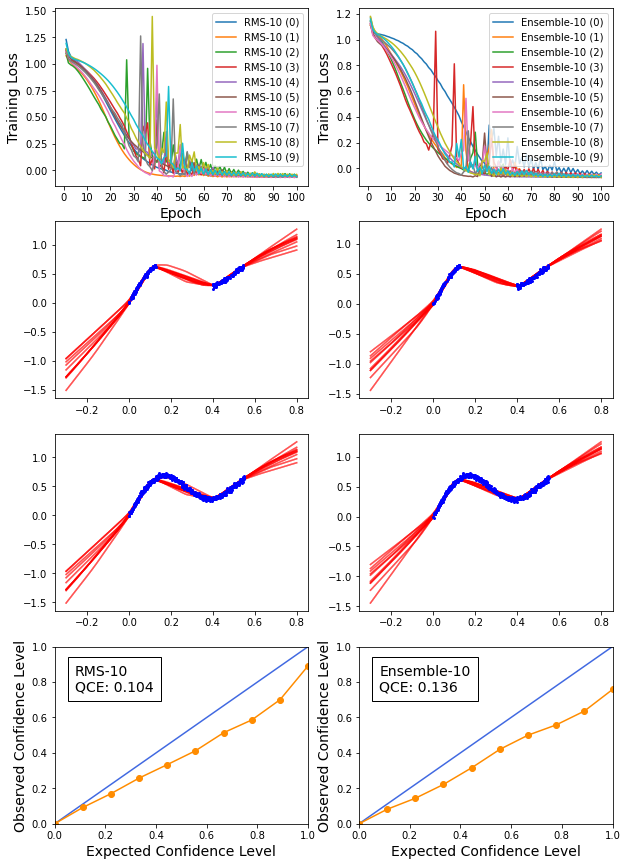

In [30]:
from training.rms import RMSModule
from training.ensemble import Ensemble

torch.manual_seed(42)
dataset, trainloader, testset = gap_datasets(device)

layers = [
    ("fc", (1, 32)),
    ("relu", ()),
    ("fc", (32, 32)),
    ("relu", ()),
    ("fc", (32, 1))
]
rms = Ensemble([wrap(RMSModule(layers, torch.tensor(1.0), NOISE, 5.0)) for _ in range(10)])
rms.train_model(100, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0)

ensemble = Ensemble([wrap(PointPredictor(layers)) for _ in range(10)])
ensemble.train_model(100, sgd(lr=0.001), "mean", trainloader, 20, device, report_every_epochs=0)

fig, results = plot_grid(dataset, testset, [("RMS-10", rms, 100), ("Ensemble-10", ensemble, 100)], device, plot_ground_truth=False)
